Notes: 
1. Clean up trend section
2. Make functions for straight line, parabolic and modified exponential as they are getting used again and again
3. All functions using log are giving Nans when y_t = 0 being included. Fix this

In [138]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [140]:
class TS:
    '''
    Class that implements the various time series analysis methods as given in FAS and kendall.
    '''
    def __init__(self, data_loc):
        '''
        Initializes object with a dataset. Index gets changed to datetime type too. 
        '''
        data = pd.read_csv(data_loc)
        data.set_index('dt', inplace= True)
        data.index = pd.to_datetime(data.index)
        self.data = data
    
    def set_start_end(self, start, end=None):
        '''
        If lots of operations are being done to a subset of data, this method can be used to build a subset of data that 
        can be operated on. Using subset = True in following methods will allow class to use this subset dataset.
        '''
        if end:
            self.sub = self.data.loc[end:start]
        else:
            self.sub = self.data.loc[:start]
        
    def plot_data(self, col, start = None, end = None, figsize = (12,6), subset = False):
        '''
        Plot the data for a particular column(s) with index(datetime) on x-axis.
        '''
        if subset:
            sub = self.sub[col]
        else:
            if end:
                sub = self.data[col].loc[end:start]
            else:
                sub = self.data[col].loc[:start]
        fig, ax = plt.subplots(1,1, figsize = figsize)
        sub.plot(ax = ax)
    
    def trend(self, col, method, subset = False):
        '''
        Use different methods for trend analysis to get values of trend. Note: Should ideally use matrix methods to solve these 
        equations.

        '''
        if subset:
            data = self.sub.sort_index()
        else:
            data = self.data.sort_index()
        
        data['t'] = data.time - data.time.median()
        data = data[[col, 't']]
        
        sigma_y_t = np.dot(data.t, data[col])
        y_bar = data[col].mean()
        t_bar = data.t.mean()
        n = data.shape[0]
        sigma_y_square = np.sum(np.square(data[col]))
        sigma_t_square = np.sum(np.square(data.t))
        
        if method == 'straight line':
            b = (sigma_y_t - n*y_bar*t_bar)/(sigma_t_square - n*(t_bar)**2)
            a = y_bar - b*t_bar
            
            data['trend'] = a + b*data.t
            self.data['straight_line_trend'] = data['trend'] 
            if subset:
                self.sub['straight_line_trend'] = data['trend']
                
        elif method == 'parabolic':
            sigma_y_t_square = np.dot(np.square(data.t), data[col])
            sigma_t_four = np.sum(data.t**4)
            sigma_t_cube = np.sum(data.t**3)
            
            mini_denom = sigma_t_square-n*t_bar**2
            num = sigma_y_t_square - y_bar*sigma_t_square + (n*t_bar*y_bar-sigma_y_t)*(sigma_t_cube-t_bar*sigma_t_square)/mini_denom
            denom = (-1*sigma_t_square**2)/n + sigma_t_four - (-t_bar*sigma_t_square + sigma_t_cube)*(sigma_t_cube-t_bar*sigma_t_square)/mini_denom
            c = num/denom
            b = (sigma_y_t-n*y_bar*t_bar-c*(-t_bar*sigma_t_square+sigma_t_cube))/mini_denom
            a = y_bar - b*t_bar - c*sigma_t_square/n
            
            data['trend'] = a + b*data.t + c*data.t**2
            self.data['parabolic_trend'] = data['trend'] 
            if subset:
                self.sub['parabolic_trend'] = data['trend']
                
        elif method == 'exponential':
            data[col] = np.log(data[col])
            
            sigma_y_t = np.dot(data.t, data[col])
            y_bar = data[col].mean()
            t_bar = data.t.mean()
            n = data.shape[0]
            sigma_y_square = np.sum(np.square(data[col]))
            sigma_t_square = np.sum(np.square(data.t))
            
            B = (sigma_y_t - n*y_bar*t_bar)/(sigma_t_square - n*(t_bar)**2)
            A = y_bar - B*t_bar
            
            data['trend'] = np.exp(A + B*data.t)
            self.data['exponential_trend'] = data['trend'] 
            if subset:
                self.sub['exponential_trend'] = data['trend']
            
        elif method == '2_deg_log':
            data[col] = np.log(data[col])
            
            sigma_y_t = np.dot(data.t, data[col])
            y_bar = data[col].mean()
            t_bar = data.t.mean()
            n = data.shape[0]
            sigma_y_square = np.sum(np.square(data[col]))
            sigma_t_square = np.sum(np.square(data.t))
            
            sigma_y_t_square = np.dot(np.square(data.t), data[col])
            sigma_t_four = np.sum(data.t**4)
            sigma_t_cube = np.sum(data.t**3)
            
            mini_denom = sigma_t_square-n*t_bar**2
            num = sigma_y_t_square - y_bar*sigma_t_square + (n*t_bar*y_bar-sigma_y_t)*(sigma_t_cube-t_bar*sigma_t_square)/mini_denom
            denom = (-1*sigma_t_square**2)/n + sigma_t_four - (-t_bar*sigma_t_square + sigma_t_cube)*(sigma_t_cube-t_bar*sigma_t_square)/mini_denom
            C = num/denom
            B = (sigma_y_t-n*y_bar*t_bar-C*(-t_bar*sigma_t_square+sigma_t_cube))/mini_denom
            A = y_bar - B*t_bar - C*sigma_t_square/n
            
            data['trend'] = np.exp(A + B*data.t + C*data.t**2)
            self.data['2_deg_log_trend'] = data['trend']
            if subset:
                self.sub['2_deg_log_trend'] = data['trend']
        
        elif method=='modified_exponential':
            # solved using the method of partial sums
            
            # make sure data can be divided into 3 equal parts
            if data.shape[0]%3==0:
                n = data.shape[0]
            else:
                remainder = data.shape[0]%3
                n = data.shape[0]-remainder
            
            cd= int(n/3) # cd = common_divisor because this will be used a lot in the below formulae 
            data = data.iloc[:n]
            data['t'] = range(1,n+1)
            s1 = data.iloc[:cd][col].sum()
            s2 = data.iloc[cd:2*cd][col].sum()
            s3 = data.iloc[2*cd:][col].sum()
            c = ((s3-s2)/(s2-s1))**(1/cd)
            b =  ((c-1)*(s2-s1)**3)/(c*(s3-2*s2+s1)**2)
            a = (s1-b*c*(c**cd-1)/(c-1))/cd
            
            data['trend'] = a + b*(c**data['t'])
            self.data['modified_exponential_trend'] = data['trend']
            if subset:
                self.sub['modified_exponential_trend'] = data['trend']
                
        elif method == "gompertz":
            data[col] = np.log(data[col])
            # same as above implementation
            if data.shape[0]%3==0:
                n = data.shape[0]
            else:
                remainder = data.shape[0]%3
                n = data.shape[0]-remainder
                            
            cd= int(n/3) # cd = common_divisor because this will be used a lot in the below formulae 
            data = data.iloc[:n]
            data['t'] = range(1,n+1)
            s1 = data.iloc[:cd][col].sum()
            s2 = data.iloc[cd:2*cd][col].sum()
            s3 = data.iloc[2*cd:][col].sum()
            c = ((s3-s2)/(s2-s1))**(1/cd)
            b =  ((c-1)*(s2-s1)**3)/(c*(s3-2*s2+s1)**2)
            a = (s1-b*c*(c**cd-1)/(c-1))/cd
            
            data['trend'] = np.exp(a + b*(c**data['t']))
            self.data['gompertz_trend'] = data['trend']
            if subset:
                self.sub['gompertz_trend'] = data['trend']               

In [149]:
# loading data
ltc = TS(data_loc='../Desktop/TS/ltc.csv')

In [150]:
# making a subset of data to work on 
ltc.set_start_end(start = '2019', end= '2019')

In [151]:
# calculating trend values
trends = ['straight line', 'parabolic','exponential','2_deg_log', 'modified_exponential', 'gompertz']
for i in trends :
    ltc.trend(col = 'open', method = i, subset = True)

C:\Users\Ishan Nangia\anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Ishan Nangia\anaconda3\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Ishan Nangia\anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [152]:
# checking new dataframe
ltc.data.head()

,close,high,low,open,time,volumefrom,volumeto,year,straight_line_trend,parabolic_trend,exponential_trend,2_deg_log_trend,modified_exponential_trend,gompertz_trend
dt,,,,,,,,,,,,,,
2019-09-07 00:00:00+00:00,65.31,65.49,65.09,65.44,1567814400,2647.04,176114.00,2019,113.276777,80.151806,124.901793,74.498434,NaN,NaN
2019-09-06 23:00:00+00:00,65.44,65.52,64.94,65.11,1567810800,4519.61,298207.02,2019,113.264401,80.172688,124.877528,74.522615,98.238652,95.256379
2019-09-06 22:00:00+00:00,65.11,65.51,65.07,65.50,1567807200,5899.30,384453.27,2019,113.252025,80.193559,124.853268,74.546791,98.238085,95.256069
2019-09-06 21:00:00+00:00,65.50,65.50,64.88,65.11,1567803600,6109.94,398098.79,2019,113.239649,80.214419,124.829013,74.570962,98.237517,95.255759
2019-09-06 20:00:00+00:00,65.11,65.34,64.08,65.34,1567800000,30096.39,1943477.44,2019,113.227273,80.235267,124.804762,74.595128,98.236949,95.255448


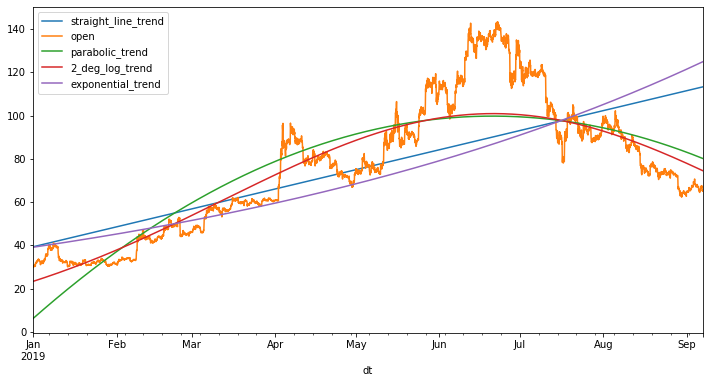

In [156]:
# plotting trend valueswith actual values
ltc.plot_data(col=['straight_line_trend','open', 'parabolic_trend', '2_deg_log_trend', 'exponential_trend'], subset =True)

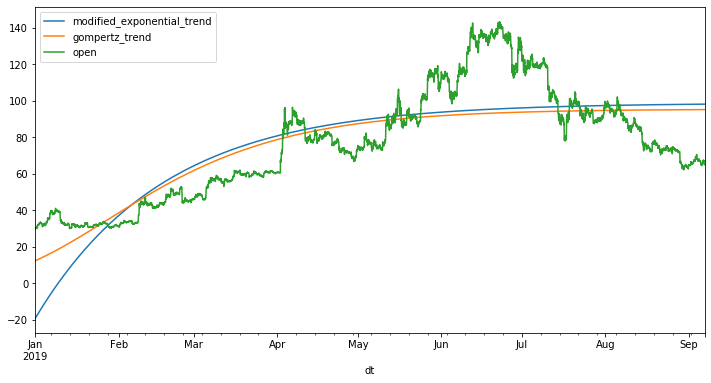

In [155]:
# plotting trend valueswith actual values
ltc.plot_data(col=['modified_exponential_trend','gompertz_trend', 'open'], subset =True)